In [2]:
import argparse
import sys
import re
import os, glob, datetime, time
import numpy as np
import torch
import torch.nn as nn
from torch.nn.modules.loss import _Loss
import torch.nn.init as init
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
import data_generator as dg
from data_generator import DenoisingDataset
import warnings

In [3]:
warnings.filterwarnings('ignore')

Baseline

In [4]:
# Params
if any(["jupyter" in arg for arg in sys.argv]):
    # Simulate command line arguments (replace these with your desired defaults)
    sys.argv = ['ipykernel_launcher.py', '--model', 'DnCNN', '--batch_size', '64', '--train_data', 'data/Train400', '--sigma', '4', '--epoch', '3', '--lr', '0.0005']

parser = argparse.ArgumentParser(description='PyTorch DnCNN')
parser.add_argument('--model', default='DnCNN', type=str, help='choose a type of model')
parser.add_argument('--batch_size', default=64, type=int, help='batch size')
parser.add_argument('--train_data', default='data/Train400', type=str, help='path of train data')
parser.add_argument('--sigma', default=4, type=int, help='noise level')
parser.add_argument('--epoch', default=3, type=int, help='number of train epoches')
parser.add_argument('--lr', default=5e-4, type=float, help='initial learning rate for Adam')
args = parser.parse_args()
batch_size = args.batch_size
cuda = torch.cuda.is_available()
n_epoch = args.epoch
sigma = args.sigma

save_dir = os.path.join('models', args.model+'_' + 'sigma' + str(sigma))

if not os.path.exists(save_dir):
    os.mkdir(save_dir)


class DnCNN(nn.Module):
    def __init__(self, out_channels=64, in_channels=1, kernel_size=3):
        super(DnCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1, stride=1)
        self.BN = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        output_layers = []
        for _ in range(10):
            for sub in self.make_Residual():
                output_layers.append(sub)
        self.out = nn.Sequential(*output_layers)
        self.res = nn.Conv2d(64, 1, kernel_size=3, padding=1, stride=1)

    def make_Residual(self, in_channels=64, out_channels=64, kernel_size=3):
        i = 0
        layers = []
        for i in range(2):
            layers.append(nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=1, bias=True))
            layers.append(nn.BatchNorm2d(64, eps=0.0001, momentum=0.95))
            layers.append(nn.ReLU(inplace=True))
        return layers


    def forward(self, x):
        y = x
        out = self.relu(self.BN(self.conv1(x)))
        out = self.out(out)
        dn = y - self.res(out)
        return dn


    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.orthogonal_(m.weight)
                print('init weight')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)


class sum_squared_error(_Loss):  # PyTorch 0.4.1
    """
    Definition: sum_squared_error = 1/2 * nn.MSELoss(reduction = 'sum')
    The backward is defined as: input-target
    """
    def __init__(self, size_average=None, reduce=None, reduction='sum'):
        super(sum_squared_error, self).__init__(size_average, reduce, reduction)

    def forward(self, input, target):
        # return torch.sum(torch.pow(input-target,2), (0,1,2,3)).div_(2)
        return torch.nn.functional.mse_loss(input, target, size_average=None, reduce=None, reduction='sum').div_(2)


def log(*args, **kwargs):
     print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S:"), *args, **kwargs)

In [5]:
import torch

# Attempt to manually select a CUDA device
try:
    torch.cuda.current_device()
    print("Current CUDA device:", torch.cuda.get_device_name())
except Exception as e:
    print("Error accessing CUDA device:", str(e))

Current CUDA device: NVIDIA GeForce RTX 3070 Laptop GPU


In [6]:
from tqdm import tqdm

if __name__ == '__main__':
    # model selection
    print('===> Building model')
    model = DnCNN()

    initial_epoch = 0
    model.train()
    # criterion = nn.MSELoss(reduction = 'sum')  # PyTorch 0.4.1
    criterion = sum_squared_error()
    if cuda:
        model = model.cuda()
         # device_ids = [0]
         # model = nn.DataParallel(model, device_ids=device_ids).cuda()
         # criterion = criterion.cuda()
    optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay = 1e-4)
    scheduler = MultiStepLR(optimizer, milestones=[3, 6, 9], gamma=0.2)  # learning rates
    for epoch in tqdm(range(initial_epoch, n_epoch)):

        scheduler.step(epoch)  # step to the learning rate in this epcoh
        xs = dg.datagenerator(data_dir=args.train_data)
        xs = xs.astype('float32')/255.0
        xs = torch.from_numpy(xs.transpose((0, 3, 1, 2)))  # tensor of the clean patches, NXCXHXW
        DDataset = DenoisingDataset(xs, sigma)
        DLoader = DataLoader(dataset=DDataset, num_workers=4, drop_last=True, batch_size=batch_size, shuffle=True)
        epoch_loss = 0
        start_time = time.time()

        for n_count, batch_yx in enumerate(DLoader):
                optimizer.zero_grad()
                if cuda:
                    batch_x, batch_y = batch_yx[1].cuda(), batch_yx[0].cuda()
                loss = criterion(model(batch_y), batch_x)
                epoch_loss += loss.item()
                loss.backward()
                optimizer.step()
                if n_count % 10 == 0:
                    print('%4d %4d / %4d loss = %2.4f' % (epoch+1, n_count, xs.size(0)//batch_size, loss.item()/batch_size))
        elapsed_time = time.time() - start_time

        log('epcoh = %4d , loss = %4.4f , time = %4.2f s' % (epoch+1, epoch_loss/n_count, elapsed_time))
        np.savetxt('train_result.txt', np.hstack((epoch+1, epoch_loss/n_count, elapsed_time)), fmt='%2.4f')
        # torch.save(model.state_dict(), os.path.join(save_dir, 'model_%03d.pth' % (epoch+1)))
        torch.save(model, os.path.join(save_dir, 'model_%03d.pth' % (epoch+1)))


===> Building model


  0%|          | 0/3 [00:00<?, ?it/s]


AxisError: axis 3 is out of bounds for array of dimension 2

Attention

In [ ]:
# Params
if any(["jupyter" in arg for arg in sys.argv]):
    # Simulate command line arguments (replace these with your desired defaults)
    sys.argv = ['ipykernel_launcher.py', '--model', 'DnCNN', '--batch_size', '4', '--train_data', 'data/Train400', '--sigma', '4', '--epoch', '2', '--lr', '0.0005']

parser = argparse.ArgumentParser(description='PyTorch DnCNN')
parser.add_argument('--model', default='DnCNN', type=str, help='choose a type of model')
parser.add_argument('--batch_size', default=4, type=int, help='batch size')
parser.add_argument('--train_data', default='data/Train400', type=str, help='path of train data')
parser.add_argument('--sigma', default=4, type=int, help='noise level')
parser.add_argument('--epoch', default=2, type=int, help='number of train epoches')
parser.add_argument('--lr', default=5e-4, type=float, help='initial learning rate for Adam')
args = parser.parse_args()
batch_size = args.batch_size
cuda = torch.cuda.is_available()
n_epoch = args.epoch
sigma = args.sigma

save_dir = os.path.join('models', args.model+'_' + 'sigma' + str(sigma))

if not os.path.exists(save_dir):
    os.mkdir(save_dir)

class Residual_Blocks(nn.Module):
    def __init__(self, in_channels=64, out_channels=64, padding = 1):
        super(Residual_Blocks, self).__init__()
        self.convx_1 = nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False)
        self.Leakyrelu = nn.LeakyReLU(inplace=True)
        self.BN = nn.BatchNorm2d(64)
        self.convx_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False)
        self.Leakyrelu = nn.LeakyReLU(inplace=True)

    def forward(self, x):
        x = self.BN(self.Leakyrelu(self.convx_1(x)))
        out = self.BN(self.Leakyrelu(self.convx_2(x)))
        return out

class Attention(nn.Module):
    def __init__(self, reduction=8):
        super(Attention, self).__init__()
        self.red = reduction
        self.query = nn.Conv2d(in_channels=64, out_channels=64//self.red, kernel_size=3, padding=1, stride=1, bias=False)
        self.value = nn.Conv2d(in_channels=64, out_channels=64//self.red, kernel_size=3, padding=1, stride=1, bias=False)
        self.key = nn.Conv2d(in_channels=64, out_channels=64//self.red, kernel_size=3, padding=1, stride=1, bias=False)
        self.out = nn.Conv2d(in_channels=64//self.red, out_channels=64, kernel_size=3, padding=1, stride=1, bias=False)

    def forward(self, x):
        b, c, h, w = x.size()
        query = self.query(x).view(b, -1, h*w)
        value = self.value(x).view(b, -1, h*w)
        key = self.key(x).view(b, -1, h*w)
        mul_1 = torch.bmm(query, value.transpose(1,2))
        attention_weights = mul_1 / np.sqrt(64//self.red)
        res_1 = nn.functional.softmax(attention_weights, dim=-1)
        mul_2 = torch.bmm(res_1, key).view(b, -1, h, w)
        out = self.out(mul_2)
        return x + out


class DnCNN(nn.Module):
    def __init__(self, n_channels=64, image_channels=1):
        super(DnCNN, self).__init__()
        self.conv1 = nn.Conv2d(image_channels, n_channels, kernel_size=3, padding=1, bias=False)
        self.attention = Attention()
        self.act = nn.LeakyReLU(inplace=True)
        self.out = nn.Sequential(*[Residual_Blocks() for _ in range(1)])
        self.dn = nn.Conv2d(64, 1, kernel_size=3, padding=1, bias=True)
        self._initialize_weights()

    def forward(self, x):
        y = x
        out = self.act(self.attention(self.conv1(x)))
        out = self.out(out)
        dn = y - self.dn(out)
        return dn

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.orthogonal_(m.weight)
                print('init weight')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)


class sum_squared_error(_Loss):  # PyTorch 0.4.1
    """
    Definition: sum_squared_error = 1/2 * nn.MSELoss(reduction = 'sum')
    The backward is defined as: input-target
    """
    def __init__(self, size_average=None, reduce=None, reduction='sum'):
        super(sum_squared_error, self).__init__(size_average, reduce, reduction)

    def forward(self, input, target):
        # return torch.sum(torch.pow(input-target,2), (0,1,2,3)).div_(2)
        return torch.nn.functional.mse_loss(input, target, size_average=None, reduce=None, reduction='sum').div_(2)


def log(*args, **kwargs):
     print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S:"), *args, **kwargs)

In [ ]:
from tqdm import tqdm

if __name__ == '__main__':
    # model selection
    print('===> Building model')
    model = DnCNN()

    initial_epoch = 0
    model.train()
    # criterion = nn.MSELoss(reduction = 'sum')  # PyTorch 0.4.1
    criterion = sum_squared_error()
    if cuda:
        model = model.cuda()
         # device_ids = [0]
         # model = nn.DataParallel(model, device_ids=device_ids).cuda()
         # criterion = criterion.cuda()
    optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay = 1e-4)
    scheduler = MultiStepLR(optimizer, milestones=[3, 6, 9], gamma=0.2)  # learning rates
    for epoch in tqdm(range(initial_epoch, n_epoch)):

        scheduler.step(epoch)  # step to the learning rate in this epcoh
        xs = dg.datagenerator(data_dir=args.train_data)
        xs = xs.astype('float32')/255.0
        xs = torch.from_numpy(xs.transpose((0, 3, 1, 2)))  # tensor of the clean patches, NXCXHXW
        DDataset = DenoisingDataset(xs, sigma)
        DLoader = DataLoader(dataset=DDataset, num_workers=4, drop_last=True, batch_size=batch_size, shuffle=True)
        epoch_loss = 0
        start_time = time.time()

        for n_count, batch_yx in enumerate(DLoader):
                optimizer.zero_grad()
                if cuda:
                    batch_x, batch_y = batch_yx[1].cuda(), batch_yx[0].cuda()
                loss = criterion(model(batch_y), batch_x)
                epoch_loss += loss.item()
                loss.backward()
                optimizer.step()
                if n_count % 10 == 0:
                    print('%4d %4d / %4d loss = %2.4f' % (epoch+1, n_count, xs.size(0)//batch_size, loss.item()/batch_size))
        elapsed_time = time.time() - start_time

        log('epcoh = %4d , loss = %4.4f , time = %4.2f s' % (epoch+1, epoch_loss/n_count, elapsed_time))
        np.savetxt('train_result.txt', np.hstack((epoch+1, epoch_loss/n_count, elapsed_time)), fmt='%2.4f')
        # torch.save(model.state_dict(), os.path.join(save_dir, 'model_%03d.pth' % (epoch+1)))
        torch.save(model, os.path.join(save_dir, 'model_%03d.pth' % (epoch+1)))

===> Building model
init weight
init weight
init weight
init weight
init weight
init weight
init weight
init weight


  0%|          | 0/3 [00:00<?, ?it/s]

^_^-training data finished-^_^
   1    0 / 3724 loss = 4683.0400
   1   10 / 3724 loss = 2759.0498
   1   20 / 3724 loss = 1525.6687
   1   30 / 3724 loss = 1285.4995
   1   40 / 3724 loss = 777.1465
   1   50 / 3724 loss = 488.3605
   1   60 / 3724 loss = 213.9298
   1   70 / 3724 loss = 100.2484
   1   80 / 3724 loss = 77.1491
   1   90 / 3724 loss = 46.6285
   1  100 / 3724 loss = 50.5071
   1  110 / 3724 loss = 46.8308
   1  120 / 3724 loss = 37.3724
   1  130 / 3724 loss = 46.8397
   1  140 / 3724 loss = 55.8464
   1  150 / 3724 loss = 35.2588
   1  160 / 3724 loss = 22.9932
   1  170 / 3724 loss = 27.9490
   1  180 / 3724 loss = 24.1423
   1  190 / 3724 loss = 51.5576
   1  200 / 3724 loss = 40.2603
   1  210 / 3724 loss = 41.9607
   1  220 / 3724 loss = 17.9479
   1  230 / 3724 loss = 17.7618
   1  240 / 3724 loss = 24.6536
   1  250 / 3724 loss = 20.0604
   1  260 / 3724 loss = 24.6743
   1  270 / 3724 loss = 40.9228
   1  280 / 3724 loss = 20.0776
   1  290 / 3724 loss = 18.10

 33%|███▎      | 1/3 [01:52<03:44, 112.37s/it]

   1 3720 / 3724 loss = 14.5827
2025-03-14 22:41:45: epcoh =    1 , loss = 2715.8785 , time = 106.24 s
^_^-training data finished-^_^
   2    0 / 3724 loss = 14.5308
   2   10 / 3724 loss = 8.4303
   2   20 / 3724 loss = 20.7693
   2   30 / 3724 loss = 8.3951
   2   40 / 3724 loss = 10.9541
   2   50 / 3724 loss = 7.2948
   2   60 / 3724 loss = 9.2099
   2   70 / 3724 loss = 7.7832
   2   80 / 3724 loss = 56.2276
   2   90 / 3724 loss = 14.9615
   2  100 / 3724 loss = 8.8512
   2  110 / 3724 loss = 6.9214
   2  120 / 3724 loss = 10.4388
   2  130 / 3724 loss = 26.0357
   2  140 / 3724 loss = 8.4575
   2  150 / 3724 loss = 6.0251
   2  160 / 3724 loss = 10.3536
   2  170 / 3724 loss = 12.5594
   2  180 / 3724 loss = 8.7114
   2  190 / 3724 loss = 10.2485
   2  200 / 3724 loss = 9.9922
   2  210 / 3724 loss = 9.9161
   2  220 / 3724 loss = 10.9474
   2  230 / 3724 loss = 7.5078
   2  240 / 3724 loss = 7.5638
   2  250 / 3724 loss = 9.0720
   2  260 / 3724 loss = 8.4224
   2  270 / 3724 l

 67%|██████▋   | 2/3 [03:42<01:51, 111.06s/it]

2025-03-14 22:43:36: epcoh =    2 , loss = 1026.9959 , time = 105.81 s
^_^-training data finished-^_^
   3    0 / 3724 loss = 12.6310
   3   10 / 3724 loss = 10.6213
   3   20 / 3724 loss = 9.7382
   3   30 / 3724 loss = 53.7886
   3   40 / 3724 loss = 33.7804
   3   50 / 3724 loss = 6.7979
   3   60 / 3724 loss = 17.4997
   3   70 / 3724 loss = 11.2571
   3   80 / 3724 loss = 16.2881
   3   90 / 3724 loss = 15.3077
   3  100 / 3724 loss = 7.5163
   3  110 / 3724 loss = 9.2210
   3  120 / 3724 loss = 5.6134
   3  130 / 3724 loss = 7.7754
   3  140 / 3724 loss = 19.5352
   3  150 / 3724 loss = 35.5361
   3  160 / 3724 loss = 11.4559
   3  170 / 3724 loss = 8.5864
   3  180 / 3724 loss = 11.4933
   3  190 / 3724 loss = 11.1528
   3  200 / 3724 loss = 8.5215
   3  210 / 3724 loss = 10.1514
   3  220 / 3724 loss = 6.3721
   3  230 / 3724 loss = 11.4650
   3  240 / 3724 loss = 16.8634
   3  250 / 3724 loss = 6.2608
   3  260 / 3724 loss = 12.1988
   3  270 / 3724 loss = 16.7346
   3  280 / 

100%|██████████| 3/3 [05:34<00:00, 111.37s/it]

   3 3720 / 3724 loss = 6.7575
2025-03-14 22:45:27: epcoh =    3 , loss = 831.4560 , time = 105.55 s


Mixed

In [ ]:
# Params
if any(["jupyter" in arg for arg in sys.argv]):
    # Simulate command line arguments (replace these with your desired defaults)
    sys.argv = ['ipykernel_launcher.py', '--model', 'DnCNN', '--batch_size', '64', '--train_data', 'data/Train400', '--sigma', '4', '--epoch', '3', '--lr', '0.0005']

parser = argparse.ArgumentParser(description='PyTorch DnCNN')
parser.add_argument('--model', default='DnCNN', type=str, help='choose a type of model')
parser.add_argument('--batch_size', default=64, type=int, help='batch size')
parser.add_argument('--train_data', default='data/Train400', type=str, help='path of train data')
parser.add_argument('--sigma', default=4, type=int, help='noise level')
parser.add_argument('--epoch', default=3, type=int, help='number of train epoches')
parser.add_argument('--lr', default=5e-4, type=float, help='initial learning rate for Adam')
args = parser.parse_args()
batch_size = args.batch_size
cuda = torch.cuda.is_available()
n_epoch = args.epoch
sigma = args.sigma

save_dir = os.path.join('models', args.model+'_' + 'sigma' + str(sigma))

if not os.path.exists(save_dir):
    os.mkdir(save_dir)


class DnCNN(nn.Module):
    def __init__(self, out_channels=64, in_channels=1, kernel_size=3):
        super(DnCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1, stride=1)
        self.BN = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        output_layers = []
        for _ in range(10):
            for sub in self.make_Residual():
                output_layers.append(sub)
        self.out = nn.Sequential(*output_layers)
        self.res = nn.Conv2d(64, 1, kernel_size=3, padding=1, stride=1)

    def make_Residual(self, in_channels=64, out_channels=64, kernel_size=3):
        i = 0
        layers = []
        for i in range(2):
            layers.append(nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=1, bias=True))
            layers.append(nn.BatchNorm2d(64, eps=0.0001, momentum=0.95))
            layers.append(nn.ReLU(inplace=True))
        return layers


    def forward(self, x):
        y = x
        out = self.relu(self.BN(self.conv1(x)))
        out = self.out(out)
        dn = y - self.res(out)
        return dn


    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.orthogonal_(m.weight)
                print('init weight')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)


class sum_squared_error(_Loss):  # PyTorch 0.4.1
    """
    Definition: sum_squared_error = 1/2 * nn.MSELoss(reduction = 'sum')
    The backward is defined as: input-target
    """
    def __init__(self, size_average=None, reduce=None, reduction='sum'):
        super(sum_squared_error, self).__init__(size_average, reduce, reduction)

    def forward(self, input, target):
        # return torch.sum(torch.pow(input-target,2), (0,1,2,3)).div_(2)
        return torch.nn.functional.mse_loss(input, target, size_average=None, reduce=None, reduction='sum').div_(2)


def log(*args, **kwargs):
     print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S:"), *args, **kwargs)

In [ ]:
from tqdm import tqdm

if __name__ == '__main__':
    # model selection
    print('===> Building model')
    model = DnCNN()

    initial_epoch = 0
    model.train()
    # criterion = nn.MSELoss(reduction = 'sum')  # PyTorch 0.4.1
    criterion = sum_squared_error()
    if cuda:
        model = model.cuda()
         # device_ids = [0]
         # model = nn.DataParallel(model, device_ids=device_ids).cuda()
         # criterion = criterion.cuda()
    optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay = 1e-4)
    scheduler = MultiStepLR(optimizer, milestones=[3, 6, 9], gamma=0.2)  # learning rates
    for epoch in tqdm(range(initial_epoch, n_epoch)):

        scheduler.step(epoch)  # step to the learning rate in this epcoh
        xs = dg.datagenerator(data_dir=args.train_data)
        xs = xs.astype('float32')/255.0
        xs = torch.from_numpy(xs.transpose((0, 3, 1, 2)))  # tensor of the clean patches, NXCXHXW
        DDataset = DenoisingDataset(xs, sigma)
        DLoader = DataLoader(dataset=DDataset, num_workers=4, drop_last=True, batch_size=batch_size, shuffle=True)
        epoch_loss = 0
        start_time = time.time()

        for n_count, batch_yx in enumerate(DLoader):
                optimizer.zero_grad()
                if cuda:
                    batch_x, batch_y = batch_yx[1].cuda(), batch_yx[0].cuda()
                loss = criterion(model(batch_y), batch_x)
                epoch_loss += loss.item()
                loss.backward()
                optimizer.step()
                if n_count % 10 == 0:
                    print('%4d %4d / %4d loss = %2.4f' % (epoch+1, n_count, xs.size(0)//batch_size, loss.item()/batch_size))
        elapsed_time = time.time() - start_time

        log('epcoh = %4d , loss = %4.4f , time = %4.2f s' % (epoch+1, epoch_loss/n_count, elapsed_time))
        np.savetxt('train_result.txt', np.hstack((epoch+1, epoch_loss/n_count, elapsed_time)), fmt='%2.4f')
        # torch.save(model.state_dict(), os.path.join(save_dir, 'model_%03d.pth' % (epoch+1)))
        torch.save(model, os.path.join(save_dir, 'model_%03d.pth' % (epoch+1)))

===> Building model


  0%|          | 0/3 [00:00<?, ?it/s]

^_^-training data finished-^_^
   1    0 / 3724 loss = 4626.8955
   1   10 / 3724 loss = 1550.5450
   1   20 / 3724 loss = 1114.6875
   1   30 / 3724 loss = 739.6172
   1   40 / 3724 loss = 511.9591
   1   50 / 3724 loss = 337.5779
   1   60 / 3724 loss = 271.8437
   1   70 / 3724 loss = 210.7273
   1   80 / 3724 loss = 178.6169
   1   90 / 3724 loss = 176.6413
   1  100 / 3724 loss = 123.8297
   1  110 / 3724 loss = 143.1092
   1  120 / 3724 loss = 114.9389
   1  130 / 3724 loss = 109.2313
   1  140 / 3724 loss = 99.2370
   1  150 / 3724 loss = 82.3406
   1  160 / 3724 loss = 66.7984
   1  170 / 3724 loss = 62.8774
   1  180 / 3724 loss = 64.1437
   1  190 / 3724 loss = 134.9029
   1  200 / 3724 loss = 76.6799
   1  210 / 3724 loss = 55.8933
   1  220 / 3724 loss = 59.5522
   1  230 / 3724 loss = 66.1002
   1  240 / 3724 loss = 57.6033
   1  250 / 3724 loss = 52.0336
   1  260 / 3724 loss = 49.3239
   1  270 / 3724 loss = 54.2974
   1  280 / 3724 loss = 46.1592
   1  290 / 3724 loss =

 33%|███▎      | 1/3 [08:23<16:47, 503.55s/it]

2025-03-14 22:55:54: epcoh =    1 , loss = 3065.2128 , time = 499.27 s
^_^-training data finished-^_^
   2    0 / 3724 loss = 23.1128
   2   10 / 3724 loss = 15.5165
   2   20 / 3724 loss = 8.4208
   2   30 / 3724 loss = 35.9715
   2   40 / 3724 loss = 9.6316
   2   50 / 3724 loss = 14.0159
   2   60 / 3724 loss = 6.5708
   2   70 / 3724 loss = 17.2886
   2   80 / 3724 loss = 75.8237
   2   90 / 3724 loss = 27.5180
   2  100 / 3724 loss = 48.2234
   2  110 / 3724 loss = 25.4687
   2  120 / 3724 loss = 18.8518
   2  130 / 3724 loss = 15.5852
   2  140 / 3724 loss = 14.9972
   2  150 / 3724 loss = 11.6011
   2  160 / 3724 loss = 16.0785
   2  170 / 3724 loss = 12.1023
   2  180 / 3724 loss = 22.8729
   2  190 / 3724 loss = 10.5605
   2  200 / 3724 loss = 16.4065
   2  210 / 3724 loss = 16.2941
   2  220 / 3724 loss = 10.1928
   2  230 / 3724 loss = 9.3058
   2  240 / 3724 loss = 9.2130
   2  250 / 3724 loss = 9.6309
   2  260 / 3724 loss = 9.6502
   2  270 / 3724 loss = 16.1795
   2  280

 67%|██████▋   | 2/3 [16:47<08:23, 503.90s/it]

2025-03-14 23:04:18: epcoh =    2 , loss = 976.6774 , time = 499.42 s
^_^-training data finished-^_^
   3    0 / 3724 loss = 17.5515
   3   10 / 3724 loss = 7.7485
   3   20 / 3724 loss = 9.2986
   3   30 / 3724 loss = 7.8233
   3   40 / 3724 loss = 11.8132
   3   50 / 3724 loss = 3.5473
   3   60 / 3724 loss = 5.4256
   3   70 / 3724 loss = 9.1861
   3   80 / 3724 loss = 11.2716
   3   90 / 3724 loss = 13.3610
   3  100 / 3724 loss = 8.3931
   3  110 / 3724 loss = 5.5599
   3  120 / 3724 loss = 7.2529
   3  130 / 3724 loss = 4.9422
   3  140 / 3724 loss = 13.3126
   3  150 / 3724 loss = 7.2625
   3  160 / 3724 loss = 5.8824
   3  170 / 3724 loss = 5.0981
   3  180 / 3724 loss = 8.5388
   3  190 / 3724 loss = 5.3723
   3  200 / 3724 loss = 6.5867
   3  210 / 3724 loss = 5.4626
   3  220 / 3724 loss = 4.3019
   3  230 / 3724 loss = 6.0879
   3  240 / 3724 loss = 6.9059
   3  250 / 3724 loss = 6.5230
   3  260 / 3724 loss = 17.3125
   3  270 / 3724 loss = 11.7003
   3  280 / 3724 loss = 

100%|██████████| 3/3 [25:11<00:00, 503.89s/it]

2025-03-14 23:12:42: epcoh =    3 , loss = 437.5782 , time = 499.05 s


Test

In [ ]:
# Load the model
model_path = "/content/model_003.pth"  # Update this with the actual path
model = torch.load(model_path, weights_only=False)
model.eval()  # Switch to evaluation mode

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DnCNN(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (BN): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (out): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=0.0001, momentum=0.95, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=0.0001, momentum=0.95, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=0.0001, momentum=0.95, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(64, eps=0.0001, momentum=0.95, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
 

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch

# Function to add Gaussian noise
def add_noise(image, sigma=0.1):
    """
    Adds Gaussian noise to a grayscale image.

    Args:
        image (np.array): Clean image as a NumPy array.
        sigma (float): Noise standard deviation (default 0.1).

    Returns:
        noisy_image (np.array): Noisy version of the image.
    """
    # Normalize image to [0, 1]
    image = image.astype(np.float32) / 255.0

    # Add Gaussian noise
    noisy_image = image + np.random.normal(scale=sigma, size=image.shape)

    # Clip values to ensure they remain in range [0,1]
    noisy_image = np.clip(noisy_image, 0, 1)

    return noisy_image

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from skimage.restoration import denoise_nl_means

def compute_gradient_anisotropic(x):
    """Computes anisotropic TV gradient (less oversmoothing)."""
    grad_x = x[:, :, :, 1:] - x[:, :, :, :-1]
    grad_x = F.pad(grad_x, (0, 1, 0, 0), mode='replicate')

    grad_y = x[:, :, 1:, :] - x[:, :, :-1, :]
    grad_y = F.pad(grad_y, (0, 0, 0, 1), mode='replicate')

    grad_x = torch.sign(grad_x) * torch.clamp(grad_x.abs() - 0.002, min=0)
    grad_y = torch.sign(grad_y) * torch.clamp(grad_y.abs() - 0.002, min=0)

    return grad_x, grad_y

def compute_divergence(grad_x, grad_y):
    """Computes divergence with consistent tensor sizes."""
    div_x = F.pad(grad_x[:, :, :, :-1] - grad_x[:, :, :, 1:], (1, 0, 0, 0), mode='replicate')
    div_y = F.pad(grad_y[:, :, :-1, :] - grad_y[:, :, 1:, :], (0, 0, 1, 0), mode='replicate')

    return div_x + div_y

def tv_denoise_fista(noisy, lam=0.0001, max_iters=30, step_size=0.5, device="cpu"):
    """Performs TV denoising using FISTA optimization with improved efficiency."""
    noisy = noisy.to(device)

    if len(noisy.shape) == 2:
        noisy = noisy.unsqueeze(0).unsqueeze(0)  # (1, 1, H, W)

    x = noisy.clone()
    y = x.clone()
    t = 1.0

    for i in range(max_iters):
        grad = y - noisy
        v = y - step_size * grad

        z_x, z_y = compute_gradient_anisotropic(v)

        # Soft-thresholding
        z_x = torch.sign(z_x) * torch.clamp(z_x.abs() - lam, min=0)
        z_y = torch.sign(z_y) * torch.clamp(z_y.abs() - lam, min=0)

        # Compute divergence
        div = compute_divergence(z_x, z_y)
        x_next = v - div

        # FISTA acceleration
        t_next = 0.5 * (1 + np.sqrt(1 + 4 * t * t))
        y = x_next + ((t - 1) / t_next) * (x_next - x)
        x, t = x_next, t_next

        # Early stopping
        if torch.norm(x - x_next) < 1e-6:
            break

    return x.cpu()

In [ ]:
# Path to the clean test image
test_image_path = "/content/04.png"

clean_image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)

# Add noise to the clean image
noisy_image = add_noise(clean_image, sigma=0.05)

# Convert to PyTorch tensor and add batch & channel dimension
noisy_tensor = torch.from_numpy(noisy_image).unsqueeze(0).unsqueeze(0).to(device)  # Shape: (1, 1, H, W)

In [ ]:
# Perform inference with the trained model
noisy_tensor = noisy_tensor.to(dtype=torch.float32)
with torch.no_grad():
    denoised_tensor = model(noisy_tensor)

# Convert the denoised tensor back to NumPy format
denoised_image = denoised_tensor.squeeze().cpu().numpy()  # Remove batch & channel dim

In [ ]:
from skimage.restoration import denoise_tv_chambolle

# Example usage
device = "cuda" if torch.cuda.is_available() else "cpu"

nlm_denoised = denoise_nl_means(noisy_image, h=0.1)
nlm_denoised_tensor = torch.from_numpy(nlm_denoised).unsqueeze(0).unsqueeze(0).to(device)

tv_denoised_fista_image = tv_denoise_fista(nlm_denoised_tensor, lam=0.002, max_iters=30)

tv_denoised_post_image = denoise_tv_chambolle(denoised_image, weight=0.4)

tv_denoised_fista_post_image = tv_denoise_fista(denoised_tensor)

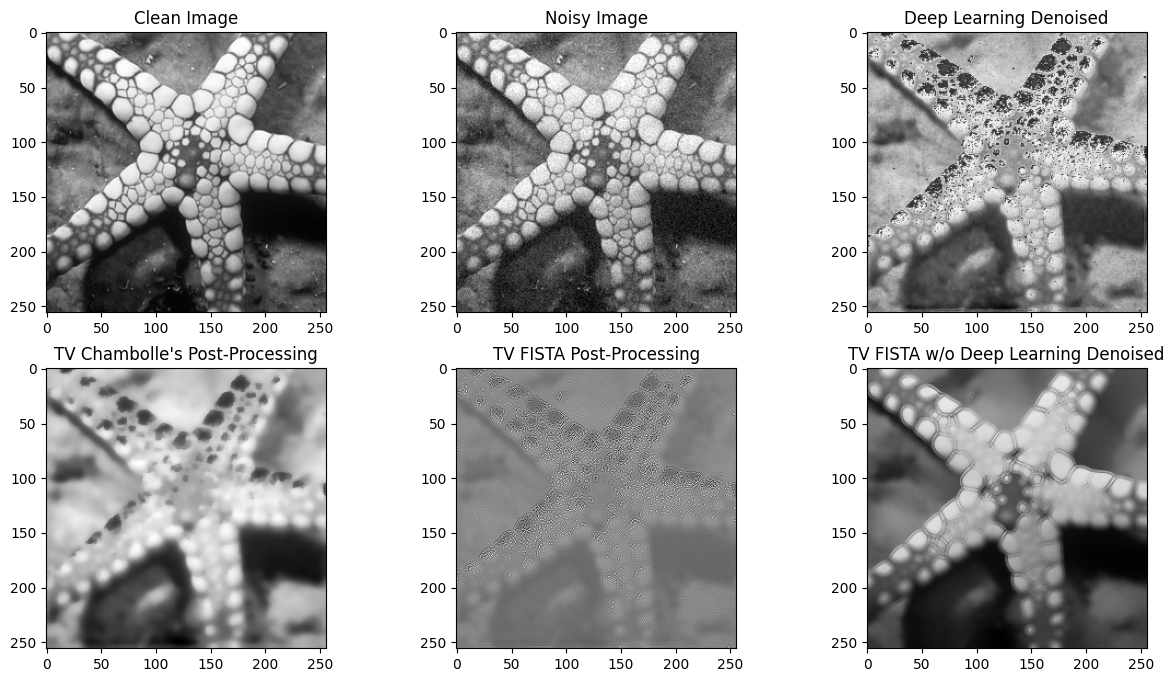

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Dummy variables (Ensure these are defined before plotting)
noisy_image = np.copy(noisy_image)
denoised_image = np.copy(denoised_image)
tv_denoised_post_image = np.copy(tv_denoised_post_image)
tv_denoised_fista_post_image = np.copy(tv_denoised_fista_post_image.squeeze().cpu().numpy())
tv_denoised_fista_image = np.copy(tv_denoised_fista_image.squeeze().cpu().numpy())

# Create the subplot
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Access subplots correctly using [row, column] indexing
axes[0, 0].imshow(clean_image, cmap='gray')
axes[0, 0].set_title("Clean Image")

axes[0, 1].imshow(noisy_image, cmap='gray')
axes[0, 1].set_title("Noisy Image")

axes[0, 2].imshow(denoised_image, cmap='gray')
axes[0, 2].set_title("Deep Learning Denoised")

axes[1, 0].imshow(tv_denoised_post_image, cmap='gray')
axes[1, 0].set_title("TV Chambolle's Post-Processing")

axes[1, 1].imshow(tv_denoised_fista_post_image, cmap='gray')
axes[1, 1].set_title("TV FISTA Post-Processing")

axes[1, 2].imshow(tv_denoised_fista_image, cmap='gray')
axes[1, 2].set_title("TV FISTA w/o Deep Learning Denoised")

plt.show()

In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Function to compute PSNR and SSIM for multiple images
def compute_metrics(clean_image, images, names):
    """
    Computes PSNR and SSIM between clean_image and a list of images.

    Args:
        clean_image (np.array): Ground truth clean image.
        images (list of np.array): List of images to compare.
        names (list of str): Names corresponding to the images.

    Returns:
        None (prints PSNR and SSIM values)
    """
    # Ensure clean image is float32 and in [0,1] range
    clean_image = clean_image.astype(np.float32) / 255.0

    results = []
    for img, name in zip(images, names):
        img = img.astype(np.float32) / 255.0  # Normalize
        psnr_value = psnr(clean_image, img)
        ssim_value = ssim(clean_image, img, data_range=img.max() - img.min())
        results.append((name, psnr_value, ssim_value))

    return results

# List of images and their names
images = [clean_image, noisy_image, denoised_image, tv_denoised_post_image, tv_denoised_fista_post_image, tv_denoised_fista_image]
names = ["Clean Image", "Noisy Image", "Denoised Image", "TV Chambolle's Post-Processing", "TV FISTA Post-Processing", "TV FISTA w/o Deep Learning"]

# Compute and display results
results = compute_metrics(clean_image, images, names)

# Convert to DataFrame for better visualization
import pandas as pd
df_results = pd.DataFrame(results, columns=["Image", "PSNR (dB)", "SSIM"])

/usr/local/lib/python3.11/dist-packages/skimage/metrics/simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)


In [ ]:
print(df_results)

                            Image  PSNR (dB)      SSIM
0                     Clean Image        inf  1.000000
1                     Noisy Image   5.331178  0.000062
2                  Denoised Image   5.321263  0.000014
3  TV Chambolle's Post-Processing   5.321154  0.000005
4        TV FISTA Post-Processing   5.321404  0.000002
5      TV FISTA w/o Deep Learning   5.330465  0.000021
